# Recommendations Using Hybrid solutions <sup>1</sup>

Lots of examples of systems that try to combine the strengths of the two main approaches.
This can be done in a number of ways:

- Combine the predictions of a content-based system and a collaborative system.
- Incorporate content-based techniques into a collaborative approach.
- Incorporate collaborative techniques into a content-based approach.
- Unifying model.

## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle
import random

## Load Data

Only loading a subset of the original data set for proof of concept reasons.

In [2]:
# 80/20 split earlier
df_train = pd.read_csv('../Data/training_data_subset.csv')
df_test = pd.read_csv('../Data/testing_data_subset.csv')

In [3]:
df_train.head(2)

,category,title,also_buy,brand,rank,also_view,main_cat,price,asin,overall,verified,reviewerID,vote,style,for_testing
0,"['Grocery & Gourmet Food', 'Candy & Chocolate'...","YumEarth Organic Gummy Bears, 10 Count","['B008CC8UXC', 'B00C25LO8S', 'B073RWDCMD', 'B0...",YumEarth,"129,438 in Grocery & Gourmet Food (","['B008CC8UXC', 'B00C25LNWA', 'B008CC8ULY', 'B0...",Grocery,NaN,B008B7JNRA,3.0,True,A35KP4ROS9KWPO,NaN,"{'Size:': ' 10 Count', 'Style:': ' Natural Gum...",False
1,"['Grocery & Gourmet Food', 'Jams, Jellies & Sw...",Bell Plantation Powdered PB2 Bundle: 1 Peanut ...,"['B06W9N8X9H', 'B06X15V3DC', 'B01ENYJX3S', 'B0...",PB2,"1,214 in Grocery & Gourmet Food (",NaN,Grocery,18.49,B00H9H56QA,5.0,True,AVAMZWS7AAI1S,NaN,{'Size:': ' Pack of 2 (1 each flavor)'},False


In [4]:
df_test.head(2)

,category,title,also_buy,brand,rank,also_view,main_cat,price,asin,overall,verified,reviewerID,vote,style,for_testing
0,"['Grocery & Gourmet Food', 'Snack Foods', 'Bar...","Grocery &amp; Gourmet Food"" />","['B01MT0QDPO', 'B00NL17FE4', 'B01NBM9OJN', 'B0...",Nature Valley,"16,921 in Grocery & Gourmet Food (",NaN,Grocery,18.04,B001E6GFR6,5.0,True,A2IUE299OONA73,NaN,NaN,True
1,"['Grocery & Gourmet Food', 'Snack Foods', 'Chi...",Gourmet Basics Smart Fries 4-Flavor Variety Pa...,"['B0763SHX4W', 'B0040FIHS8', 'B00FYR5HS4', 'B0...",Gourmet Basics,"53,167 in Grocery & Gourmet Food (",NaN,Grocery,23.99,B003AZ2ECY,4.0,True,A38NO7J1TK4R1W,NaN,NaN,True


### Evaluate

In [5]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

def evaluate_train(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(df_train.reviewerID, df_train.asin)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = df_train.overall.values
    return compute_rmse(estimated, real)

## Similarity functions

In [6]:
def euclidean(s1, s2):
    """Take two pd.Series objects and return their euclidean 'similarity'."""
    diff = s1 - s2
    return 1 / (1 + np.sqrt(np.sum(diff ** 2)))

def cosine(s1, s2):
    """Take two pd.Series objects and return their cosine similarity."""
    return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

def pearson(s1, s2):
    """Take two pd.Series objects and return a pearson correlation."""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(logsumexp(s1_c ** 2)) * np.sum(logsumexp(s2_c ** 2)))

def jaccard(s1, s2):
    dotp = np.sum(s1 * s2)
    return dotp / (np.sum(s1 ** 2) + np.sum(s2 ** 2) - dotp)

In [7]:
class Recommender(object):
    def __init__(self, similarity=pearson):
        self.overall_mean = df_train['overall'].mean()
        self.all_user_profiles = df_train.pivot_table('overall', index='asin', columns='reviewerID')
        self._similarity = similarity
        
    @property
    def similarity(self):
        return self._similarity
    
    @similarity.setter
    def similarity(self, value):
        self._similarity = value
    
    def estimate_product(self, user_id, product_id):
        all_ratings = df_train.loc[df_train.asin == product_id]
        if all_ratings.empty:
            return self.overall_mean
        all_ratings.set_index('reviewerID', inplace=True)
        their_ids = all_ratings.index
        their_ratings = all_ratings.overall
        their_profiles = self.all_user_profiles[their_ids]
        try:
            user_profile = self.all_user_profiles[user_id]
        except KeyError:
            return 4.0 * 0.5 + self.overall_mean * 0.5
        sims = their_profiles.apply(lambda profile: self.similarity(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'overall': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.overall, weights=ratings_sims.sim)

    def estimate_user(self, user_id):
        similar = df_train.loc[df_train.reviewerID == user_id]
        
        if similar.empty:
            return self.overall_mean
        else:
            return similar['overall'].mean()

    def estimate(self, user_id, product_id):
        return 0.9 * self.estimate_user(user_id) + 0.1 * self.estimate_product(user_id, product_id)
    
    def estimate_top_products(self, user_id, product_id):
        all_ratings = df_train.loc[df_train.asin == product_id]
        if all_ratings.empty:
            return self.overall_mean
        all_ratings.set_index('reviewerID', inplace=True)
        their_ids = all_ratings.index
        their_ratings = all_ratings.overall
        their_profiles = self.all_user_profiles[their_ids]
        try:
            user_profile = self.all_user_profiles[user_id]
        except KeyError:
            return self.overall_mean
        sims = their_profiles.apply(lambda profile: self.similarity(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'overall': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.overall, weights=ratings_sims.sim)

    def estimate_top_users(self, user_id):
        similar = df_train.loc[df_train.reviewerID == user_id]
        
        if similar.empty:
            return self.overall_mean
        else:
            return similar['overall'].mean()

    def estimate_top_x(self, user_id, product_id):
        return 0.5 * self.estimate_top_users(user_id) + 0.5 * self.estimate_top_products(user_id, product_id)

In [8]:
functions = [euclidean, cosine, pearson, jaccard]
for estimate in functions:
    rec = Recommender(estimate)
    print(f'RMSE using {estimate.__name__}: {evaluate_train(rec.estimate):.4f}.')

RMSE using euclidean: 0.2027.
RMSE using cosine: 0.2076.
RMSE using pearson: 0.2100.
RMSE using jaccard: 0.2036.


## Evaluate and predict on test data

Only using the most accurate similarity function, euclidean, found earlier.

In [9]:
def evaluate_test(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """

    ids_to_estimate = zip(df_test.reviewerID, df_test.asin)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = df_test.overall.values
    return compute_rmse(estimated, real)

In [10]:
reco = Recommender(euclidean)
print('RMSE for Euclidean: %s' % evaluate_test(reco.estimate))

RMSE for Euclidean: 1.1413154367862572


The recommendation for the test data is much less accurate than the estimates on the training data.
However, this is the best results so far and is better than the initial baseline found in v0.

## Other Performance Evaluation Systems

In [11]:
rec = Recommender(euclidean)
ids_to_estimate = zip(df_test.reviewerID, df_test.asin)
y_pred = np.array([rec.estimate(u,i) for (u,i) in ids_to_estimate])
y_test = df_test.overall.values

In [12]:
# Make both np arrays int for comparison
y_pred = np.rint(y_pred)

### Confusion Matrix

<AxesSubplot:>

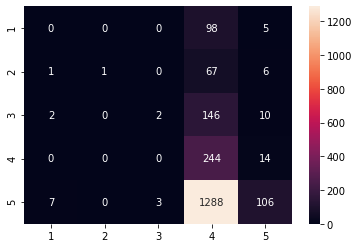

In [13]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])

### Accuracy, Precision, Recall, and F1-Score

In [14]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print('Classification report:')
print(classification_report(y_test, y_pred))

Accuracy score: 0.1765
Classification report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       103
         2.0       1.00      0.01      0.03        75
         3.0       0.40      0.01      0.02       160
         4.0       0.13      0.95      0.23       258
         5.0       0.75      0.08      0.14      1404

    accuracy                           0.18      2000
   macro avg       0.46      0.21      0.08      2000
weighted avg       0.61      0.18      0.13      2000



These evaluation metrics are all significantly lower than desired.

#### Precision-Recall curve in multi-label settings <sup>2</sup>

##### The average precision score in multi-label settings

In [15]:
# Allow multi-classification comparisons for the test and prediction scores.
y_test_bi = label_binarize(y_test, classes=[1,2,3,4,5])
y_pred_bi = label_binarize(y_pred, classes=[1,2,3,4,5])
n_classes = 5

In [16]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bi[:, i],
                                                        y_pred_bi[:, i])
    average_precision[i] = average_precision_score(y_test_bi[:, i], y_pred_bi[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bi.ravel(), y_pred_bi.ravel())
average_precision["micro"] = average_precision_score(y_test_bi, y_pred_bi,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.20


#### Plot the micro-averaged Precision-Recall curve

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.20')

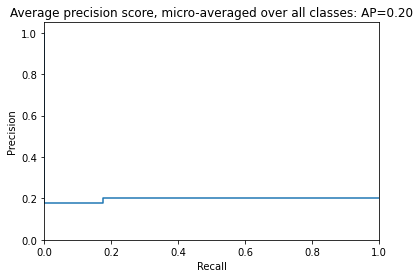

In [17]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

#### Plot Precision-Recall curve for each class and iso-f1 curves

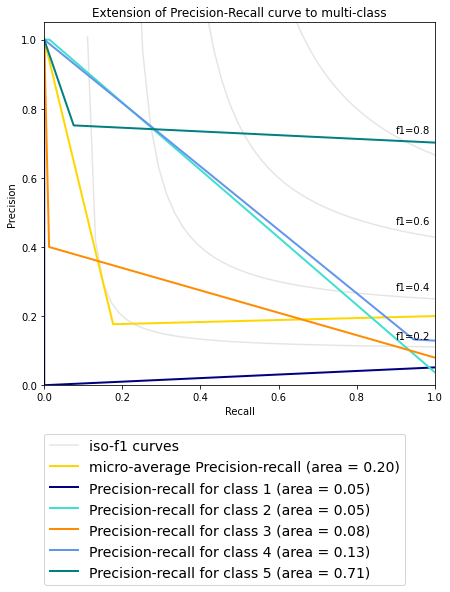

In [18]:
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i + 1, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.55), prop=dict(size=14))
plt.show()

## Top X number of recommendations

In [19]:
functions = [euclidean]
for similarity in functions:
    rec = Recommender(similarity)
    print(f'RMSE using {similarity.__name__}: {evaluate_test(rec.estimate_top_x):.4f}.') 

RMSE using euclidean: 1.1218.


In [20]:
rec = Recommender(euclidean)
ids_to_estimate = zip(df_test.reviewerID, df_test.asin)
y_pred = np.array([rec.estimate_top_x(u,i) for (u,i) in ids_to_estimate])
y_test = df_test.overall.values
# Make both np arrays int for comparison
y_pred = np.rint(y_pred)

In [21]:
def provide_x_recommendations(list_a, list_b, top_x=10):
    """ Return a random x (10 is default) recommendations that are an exact match."""
    match = []
    y_pred_rec_x = []
    y_test_rec_x = []
    assert len(list_a) == len(list_b)
    for i in range(len(list_a)):
        # Only include 5 star recommendations
        if list_a[i] > 4:
            match.append(i)
    recommendations = random.sample(match, top_x)
    for i in recommendations:
        y_pred_rec_x.append(int(y_pred[i]))
        y_test_rec_x.append(int(y_test[i]))
    return y_pred_rec_x[:top_x], y_test_rec_x[:top_x]

In [29]:
y_pred_sample, y_test_sample = provide_x_recommendations(y_pred, y_test)

<AxesSubplot:>

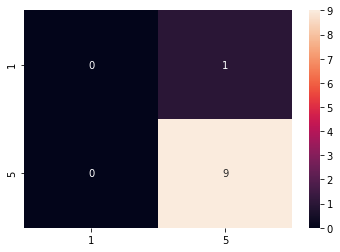

In [30]:
labels = set(y_test_sample)
cm = confusion_matrix(y_test_sample, y_pred_sample)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

In [31]:
print(f"Accuracy score: {accuracy_score(y_test_sample, y_pred_sample)}")
print('Classification report:')
print(classification_report(y_test_sample, y_pred_sample, zero_division=0))

Accuracy score: 0.9
Classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           5       0.90      1.00      0.95         9

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10



## Summary
- Evaluated estimated recommendations using several hybrid methods with RMSE.
- In all cases, the estimates on the training data were significantly better than all previous notebook versions.
- The best performing was euclidean with a RMSE of 0.2027.
- The worse performing was pearson with a RMSE of 0.21.
- However, the estimates on the testing data were not as good at 1.1413. Despite this, they were still better than all previous versions.
- Also added other performance evaluation systems; such as precision, recall, f1-score, and precision-recall curve. 
- The results for these were not good. The weighted averages were:
    - precision: 0.61
    - recall: 0.18
    - f1-score: 0.13
- Several popular recommendation systems return only 10 to 20 results.
- Creating a function to return the top x recommendations worked much better.
    - This RMSE was the best at 1.1218.
    - Limiting it to a sample of recommendations improved the results further.
        - Choosing a random sample of 10 by default.
        - Only including recommendations that were 5-stars.
        - The weighted averages were:
            - accuracy: 0.90
            - precision: 0.81
            - recall: 0.90
            - f1-score: 0.85
- These results could be improved in future versions by using more data to train on before making predictions. 

## References
1) Unata 2015 [Hands-on with PyData: How to Build a Minimal Recommendation Engine](https://www.youtube.com/watch?v=F6gWjOc1FUs).  
2) Scikit Learn 0.24.2 2021 [Precision-Recall](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html).  